# 06 - Advanced: Hyperparameter Optimization

Automatically find optimal Segmenter parameters using Optuna.

## What You'll Learn
- Define an objective function for optimization
- Use Optuna to search parameter space
- Interpret and apply results
- Compare optimized vs default configurations

## Prerequisites
```bash
pip install optuna
```

**Note:** This is an advanced topic. Start with notebooks 01-05 first.

## Setup

In [1]:
import warnings

warnings.filterwarnings("ignore")

# Check if optuna is installed
try:
    import optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    OPTUNA_AVAILABLE = True
except ImportError:
    OPTUNA_AVAILABLE = False
    print("Optuna not installed. Run: pip install optuna")

In [2]:
import yfinance as yf

from trend_classifier import Segmenter
from trend_classifier.configuration import CONFIG_REL, Config

# Download data - using Bitcoin for more varied trends
symbol = "BTC-USD"
df = yf.download(symbol, start="2019-01-01", end="2022-12-31", interval="1d", progress=False)

x = list(range(len(df)))
# Handle multi-index columns from yfinance
col = df["Close"]
y = col.squeeze().tolist() if hasattr(col, "squeeze") else col.tolist()

print(f"Downloaded {len(df)} data points for {symbol}")

Downloaded 1460 data points for BTC-USD


## The Optimization Challenge

We need to define what "good" segmentation means. This is tricky because:

**The fitting error alone is NOT a good objective!**

Why? More segments = better local fits = lower error. An optimizer will
find that creating hundreds of tiny segments minimizes fitting error,
but produces useless results.

### The Solution: Composite Objective

We balance two competing goals:
1. **Low fitting error** - trends should fit the data well
2. **Reasonable segment count** - not too many, not too few

The `calc_area_outside_trend()` metric:
```
sum(|detrended_values|) / mean(y) / len(y)
```

In [3]:
# Demonstrate the objective metric
seg_default = Segmenter(x=x, y=y, n=40)
seg_default.calculate_segments()

error_default = seg_default.calc_area_outside_trend()
print(f"Default config (n=40): {len(seg_default.segments)} segments, error={error_default:.6f}")

# Try different window sizes
for n in [20, 60, 80]:
    seg = Segmenter(x=x, y=y, n=n)
    seg.calculate_segments()
    error = seg.calc_area_outside_trend()
    print(f"n={n}: {len(seg.segments)} segments, error={error:.6f}")

Default config (n=40): 36 segments, error=0.057055
n=20: 77 segments, error=0.035070
n=60: 25 segments, error=0.061532
n=80: 19 segments, error=0.098123


## Define the Optuna Objective Function

The objective function:
1. Receives trial parameters from Optuna
2. Creates a Segmenter with those parameters
3. Returns a **composite score** (not just fitting error!)

Key insight: We penalize excessive segmentation to prevent over-fitting.

In [4]:
# Configuration for optimization
TARGET_SEGMENTS = 30  # Desired number of segments (adjust based on your needs)
SEGMENT_PENALTY_WEIGHT = 0.1  # How much to penalize deviation from target

In [5]:
if OPTUNA_AVAILABLE:
    def objective(trial):
        """Optuna objective for Segmenter hyperparameter optimization.
        
        Uses a composite score that balances:
        - Fitting error (lower = better trend fit)
        - Segment count (penalize too many or too few segments)
        """
        # Define parameter search space
        # Higher alpha/beta = fewer splits (more conservative)
        N = trial.suggest_int("N", 20, 100, step=5)
        overlap = trial.suggest_float("overlap", 0.2, 0.5, step=0.1)
        alpha = trial.suggest_float("alpha", 1.0, 10.0, step=0.5)
        beta = trial.suggest_float("beta", 1.0, 10.0, step=0.5)
        
        # Create config
        cfg = Config(
            N=N,
            overlap_ratio=overlap,
            alpha=alpha,
            beta=beta,
        )
        
        # Run segmentation
        seg = Segmenter(x=x, y=y, config=cfg)
        seg.calculate_segments()
        
        # Component 1: Fitting error
        error = seg.calc_area_outside_trend()
        
        # Component 2: Segment count penalty
        # Quadratic penalty for deviating from target segment count
        n_segments = len(seg.segments)
        segment_deviation = ((n_segments - TARGET_SEGMENTS) / TARGET_SEGMENTS) ** 2
        
        # Component 3: Short segment penalty (optional)
        # Penalize if any segment is too short (less than 5 data points)
        if seg.segments:
            min_seg_len = min(s.stop - s.start for s in seg.segments)
            short_penalty = 0.1 if min_seg_len < 5 else 0
        else:
            short_penalty = 1.0  # Heavy penalty for no segments
        
        # Composite score
        score = error + SEGMENT_PENALTY_WEIGHT * segment_deviation + short_penalty
        
        # Store segment count for later analysis
        trial.set_user_attr("n_segments", n_segments)
        trial.set_user_attr("fitting_error", error)
        
        return score

## Run Optimization

In [6]:
if OPTUNA_AVAILABLE:
    # Create study
    study = optuna.create_study(
        direction="minimize",
        study_name="trend_classifier_optimization"
    )
    
    # Run optimization (100 trials takes ~1-2 minutes)
    print("Running optimization (100 trials)...")
    study.optimize(objective, n_trials=100, show_progress_bar=True)
    
    print("\n" + "="*50)
    print("OPTIMIZATION COMPLETE")
    print("="*50)

Running optimization (100 trials)...


Best trial: 94. Best value: 0.0520039: 100%|██████████| 100/100 [00:00<00:00, 160.92it/s]


OPTIMIZATION COMPLETE


## Results

In [7]:
if OPTUNA_AVAILABLE:
    print("Best Parameters Found:")
    print("-" * 30)
    for param, value in study.best_params.items():
        print(f"  {param}: {value}")
    
    # Get detailed metrics from best trial
    best_trial = study.best_trial
    best_n_segments = best_trial.user_attrs.get("n_segments", "N/A")
    best_fitting_error = best_trial.user_attrs.get("fitting_error", study.best_value)
    
    print(f"\nBest Composite Score: {study.best_value:.6f}")
    print(f"Best Fitting Error: {best_fitting_error:.6f}")
    print(f"Best Segment Count: {best_n_segments}")
    
    # Compare to default
    seg_default = Segmenter(x=x, y=y, config=Config())
    seg_default.calculate_segments()
    default_error = seg_default.calc_area_outside_trend()
    default_n_segments = len(seg_default.segments)
    
    print(f"\nDefault Fitting Error: {default_error:.6f}")
    print(f"Default Segment Count: {default_n_segments}")
    
    if isinstance(best_fitting_error, float):
        improvement = (default_error - best_fitting_error) / default_error * 100
        print(f"\nFitting Error Improvement: {improvement:.1f}%")

Best Parameters Found:
------------------------------
  N: 60
  overlap: 0.30000000000000004
  alpha: 6.5
  beta: 1.0

Best Composite Score: 0.052004
Best Fitting Error: 0.051559
Best Segment Count: 32

Default Fitting Error: 0.061532
Default Segment Count: 25

Fitting Error Improvement: 16.2%


## Visualize Optimized Results

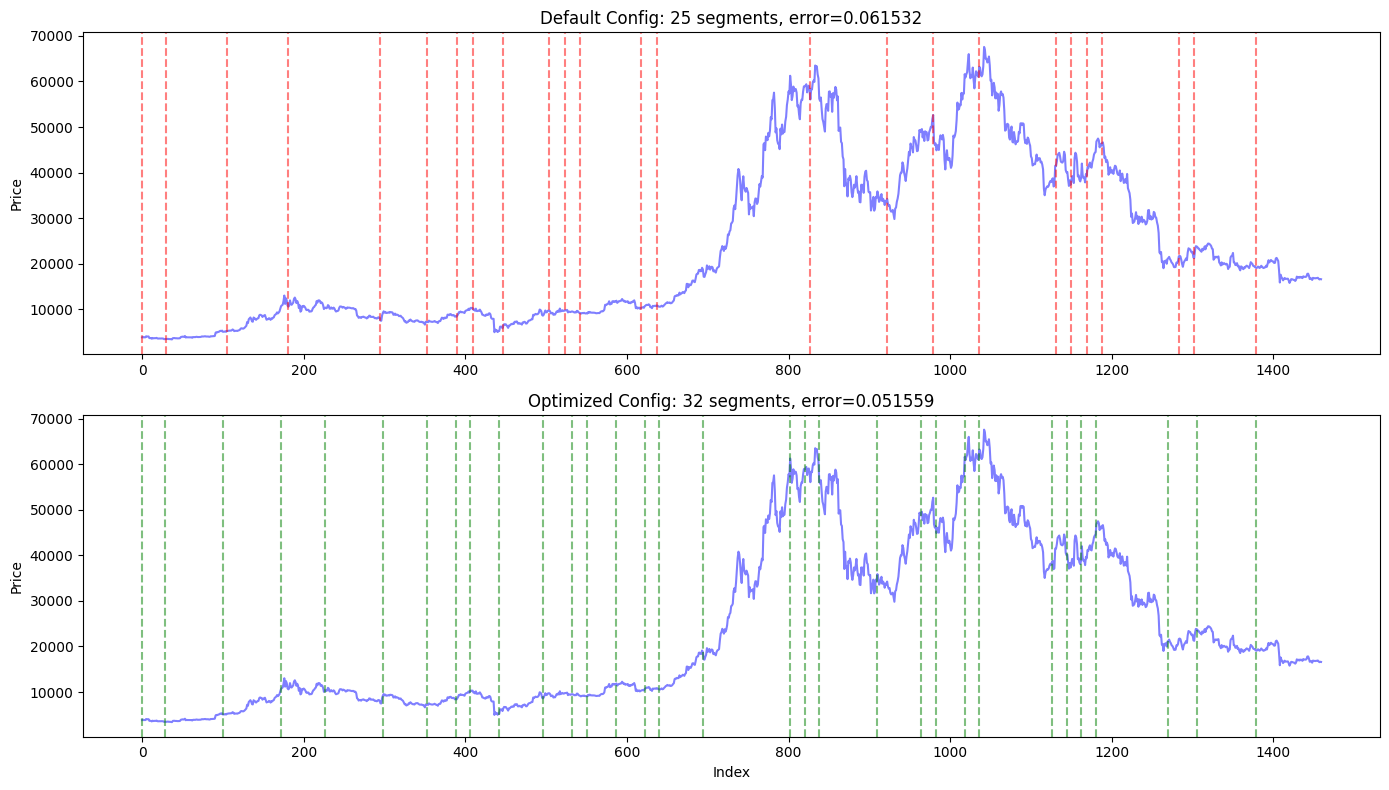

In [8]:
if OPTUNA_AVAILABLE:
    import matplotlib.pyplot as plt
    
    # Create optimized segmenter
    best_cfg = Config(
        N=study.best_params["N"],
        overlap_ratio=study.best_params["overlap"],
        alpha=study.best_params["alpha"],
        beta=study.best_params["beta"],
    )
    
    seg_optimized = Segmenter(x=x, y=y, config=best_cfg)
    seg_optimized.calculate_segments()
    optimized_error = seg_optimized.calc_area_outside_trend()
    
    # Compare default vs optimized
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Default
    seg_default = Segmenter(x=x, y=y, config=Config())
    seg_default.calculate_segments()
    
    axes[0].plot(x, y, 'b-', alpha=0.5)
    for s in seg_default.segments:
        axes[0].axvline(x=s.start, color='red', linestyle='--', alpha=0.5)
    axes[0].set_title(f"Default Config: {len(seg_default.segments)} segments, error={default_error:.6f}")
    axes[0].set_ylabel("Price")
    
    # Optimized
    axes[1].plot(x, y, 'b-', alpha=0.5)
    for s in seg_optimized.segments:
        axes[1].axvline(x=s.start, color='green', linestyle='--', alpha=0.5)
    axes[1].set_title(f"Optimized Config: {len(seg_optimized.segments)} segments, error={optimized_error:.6f}")
    axes[1].set_xlabel("Index")
    axes[1].set_ylabel("Price")
    
    plt.tight_layout()
    plt.show()

## Parameter Importance

In [9]:
if OPTUNA_AVAILABLE:
    # Which parameters matter most?
    importances = optuna.importance.get_param_importances(study)
    
    print("Parameter Importance:")
    print("-" * 30)
    for param, importance in importances.items():
        bar = "█" * int(importance * 20)
        print(f"  {param:12s}: {bar} {importance:.3f}")

Parameter Importance:
------------------------------
  alpha       : ███████ 0.392
  beta        : ██████ 0.301
  N           : ███ 0.183
  overlap     : ██ 0.123


## Optimization History

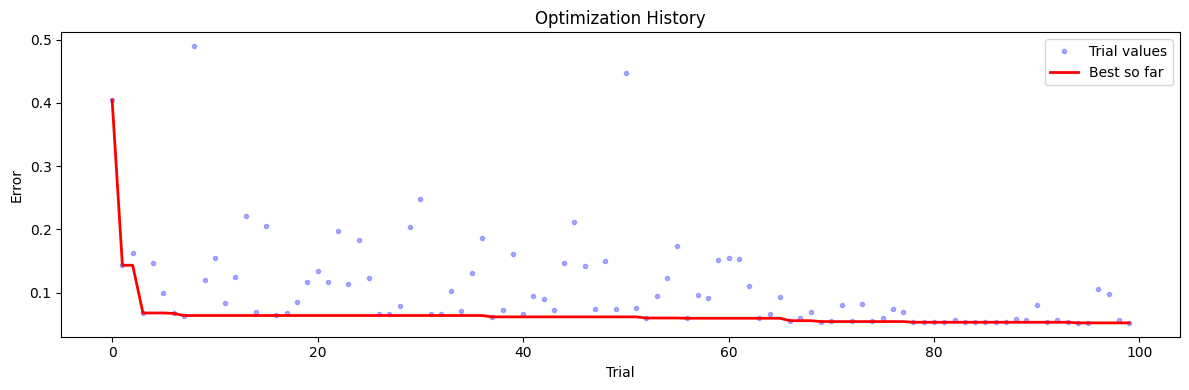

In [10]:
if OPTUNA_AVAILABLE:
    import matplotlib.pyplot as plt
    
    # Plot optimization history
    fig, ax = plt.subplots(figsize=(12, 4))
    
    trials = study.trials
    values = [t.value for t in trials]
    best_values = [min(values[:i+1]) for i in range(len(values))]
    
    ax.plot(values, 'b.', alpha=0.3, label="Trial values")
    ax.plot(best_values, 'r-', linewidth=2, label="Best so far")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Error")
    ax.set_title("Optimization History")
    ax.legend()
    
    plt.tight_layout()
    plt.show()

## Saving and Reusing Optimized Config

In [11]:
if OPTUNA_AVAILABLE:
    # Create a reusable config from best parameters
    print("To reuse these parameters, create a config like this:")
    print()
    print("from trend_classifier.configuration import Config")
    print()
    print("optimized_config = Config(")
    print(f"    N={study.best_params['N']},")
    print(f"    overlap_ratio={study.best_params['overlap']},")
    print(f"    alpha={study.best_params['alpha']},")
    print(f"    beta={study.best_params['beta']},")
    print(")")

To reuse these parameters, create a config like this:

from trend_classifier.configuration import Config

optimized_config = Config(
    N=60,
    overlap_ratio=0.30000000000000004,
    alpha=6.5,
    beta=1.0,
)


## Tips for Optimization

### 1. Adjust TARGET_SEGMENTS for your use case
- Short-term trading: more segments (50-100)
- Long-term analysis: fewer segments (10-30)

### 2. Tune SEGMENT_PENALTY_WEIGHT
- Higher (0.2-0.5): Strongly prefer target segment count
- Lower (0.01-0.05): Allow more flexibility, focus on fit quality

### 3. More trials = better results
Try 200-500 trials for production use

### 4. Different assets may need different parameters
Consider optimizing per asset class (stocks vs crypto vs forex)

### 5. Alternative objective: Only penalize excessive segments
```python
def objective_max_segments(trial):
    # ... create segmenter ...
    error = seg.calc_area_outside_trend()
    n_segments = len(seg.segments)
    # Only penalize if exceeding maximum
    penalty = 0.01 * max(0, n_segments - 50)
    return error + penalty
```

## Conclusion

You've learned how to:
- Use Optuna for automated parameter tuning
- Define custom objective functions
- Interpret and apply optimization results

This completes the trend_classifier tutorial series!